
# Work Health Plan Selection Analysis
This notebook builds cost grids and heatmaps to visualize which plan (Platinum, Gold, or Silver HDHP)
minimizes total cost under different healthcare usage scenarios. Includes calculations specific to my healthcare journey.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [26]:
# Set up display
sns.set_theme(style="whitegrid", font_scale=1.1)

 ## 1. Base assumptions for Benefits Package
 All amounts are for Employee-only coverage, per year.
 You can change the values based on what your plan and tier values are.

In [ ]:
premiums = {"Platinum": 3179.52, "Gold": 480.0, "Silver": 480.0}
deductibles = {"Platinum": 500, "Gold": 2500, "Silver": 4250}
oop_max = {"Platinum": 4000, "Gold": 7500, "Silver": 4250}
HSA_contrib = 1400
copays = {
    "Platinum": {"specialist": 20, "tier1": 10, "tier2": 30, "tier3": 75},
    "Gold": {"specialist": 30, "tier1": 10, "tier2": 30, "tier3": 75},
    "Silver":{"tier1": 10, "tier2": 30, "tier3": 75}
}

#you can change these depending on how much you think a big event would cost you
major_event_costs = [0,4500,9000]

# (min number of visits/fills, max number of visits/fills, step size to increment)
# UPDATE THIS IF YOU HAVE MORE VISITS THAN 48 A YEAR
specialist_visits = list(range(0, 48, 3))
#UPDATE THIS IS YOU HAVE MORE RX REFILLS THAN 36 A YEAR
rx_fills = list(range(0, 36, 3))

# Average cost of doctor office visit
# I assumed specialist because that's my use case which is why it's more expensive
# CHANGE THIS BASED ON YOUR AVG. VISIT COSTS
office_visit_cost = 400

# my specific prescription costs without coverage
# UPDATE THIS TO YOUR SPECIFIC RX COSTS.
tier_1_cost = 128
tier_2_cost = 1080
tier_3_cost = 0



## 2. Functions to compute total cost
This is tailored to my specific case where I have one tier 1 medication and one tier 2 medication per month.

In [ ]:
def cost_platinum(visits, tier_1_rx=0, tier_2_rx=0, tier_3_rx=0, major_event_cost=0):
    # Premium
    total = premiums["Platinum"]
    
    # Copays apply from the start
    total += copays["Platinum"]["specialist"] * visits
    total += copays["Platinum"]["tier1"] * tier_1_rx
    total += copays["Platinum"]["tier2"] * tier_2_rx
    total += copays["Platinum"]["tier3"] * tier_3_rx
    
    # Major event: pay deductible, then 20% of remainder
    if major_event_cost > 0:
        total += min(deductibles["Platinum"], major_event_cost)
        if major_event_cost > deductibles["Platinum"]:
            total += (major_event_cost - deductibles["Platinum"]) * 0.2
    
    # Cap at OOP max
    total = min(total, premiums["Platinum"] + oop_max["Platinum"])
    
    return total


def cost_gold(visits, tier_1_rx=0, tier_2_rx=0, tier_3_rx=0, major_event_cost=0):
    # Premium
    total = premiums["Gold"]
    
    # Copays apply from start
    total += copays["Gold"]["specialist"] * visits
    total += copays["Gold"]["tier1"] * tier_1_rx
    total += copays["Gold"]["tier2"] * tier_2_rx
    total += copays["Gold"]["tier3"] * tier_3_rx
    
    # Major event: pay deductible, then 30% of remainder
    if major_event_cost > 0:
        total += min(deductibles["Gold"], major_event_cost)
        if major_event_cost > deductibles["Gold"]:
            total += (major_event_cost - deductibles["Gold"]) * 0.3
    
    # Cap at OOP max
    total = min(total, premiums["Gold"] + oop_max["Gold"])
    
    return total


def cost_silver(visits, tier_1_rx=0, tier_2_rx=0, tier_3_rx=0, major_event_cost=0):
    # HDHP: Pay full cost until deductible, then 100% covered
    
    allowed = (office_visit_cost * visits + 
               tier_1_cost * tier_1_rx + 
               tier_2_cost * tier_2_rx + 
               tier_3_cost * tier_3_rx + 
               major_event_cost)
    
    # Pay everything up to deductible, then 100% covered
    paid = min(allowed, deductibles["Silver"])
    
    # Cap at OOP max (which equals deductible for this plan)
    paid = min(paid, oop_max["Silver"])
    
    # Net of employer HSA contribution
    return premiums["Silver"] + paid - HSA_contrib

## Calculate your predicted total cost for the year with each health plan.

Personal benefits cost calculator based on your individual healthcare costs. Will print the lowest cost plan for you. Don't forget to update the variables!

In [82]:
# My best plan based on my exact use case:
# 7 more months of accutane (i.e. 7 more refills)
# predicting 3 more appt. with my psych based on how meds are currently going 
# (i.e. 12 more refills with the potential for 3 additional that I'll include for worst-case scenario)

# CHANGE THESE VARIABLES TO YOUR USE CASE

# CHANGE THIS to your predicted # of visits for the year 
visits = 7 + 3 

# CHANGE THIS to your predicted # of prescription fills for each tier
tier_1_rx = 12 
tier_2_rx = 10
tier_3_rx = 0

# CHANGE THIS to your expected amount
major_event_cost = 1200 #gave myself a $1200 budget for a small accident

def calculate_all_plans(visits, tier_1_rx, tier_2_rx, tier_3_rx,major_event_cost) -> dict:
    return {
        "Platinum": cost_platinum(visits, tier_1_rx, tier_2_rx, tier_3_rx,major_event_cost),
        "Gold": cost_gold(visits, tier_1_rx, tier_2_rx, tier_3_rx,major_event_cost),
        "Silver": cost_silver(visits, tier_1_rx, tier_2_rx, tier_3_rx,major_event_cost)
    }

def calculate_best_plan(visits, tier_1_rx, tier_2_rx, tier_3_rx, major_event_cost):
    specific_cost_all_plans = calculate_all_plans(visits, tier_1_rx, tier_2_rx, tier_3_rx, major_event_cost)
    best_plan = min(specific_cost_all_plans, key=specific_cost_all_plans.get)  # Fixed: need key parameter
    best_cost = specific_cost_all_plans[best_plan]
    
    print('The costs for my specific scenario across different plans are:')
    for plan, cost in specific_cost_all_plans.items():
        print(f'  {plan}: ${cost:,.2f}')
    print(f'\nTherefore, the best healthcare plan for my specific scenario is {best_plan} at ${best_cost:,.2f}')
    
    return best_plan, best_cost

# Let's calculate woohoooo
calculate_best_plan(visits, tier_1_rx, tier_2_rx, tier_3_rx, major_event_cost)

The costs for my specific scenario across different plans are:
  Platinum: $4,439.52
  Gold: $2,400.00
  Silver: $3,330.00

Therefore, the best healthcare plan for my specific scenario is Gold at $2,400.00


('Gold', 2400.0)

## 3. Build the sensitivity grid
Note: We only use Tier 2 for the sensitivity analysis for an approximate middle ground.

In [83]:
#again, we're only using tier 2 for the approximation so we'll set the others to 0

records = []
for v in specialist_visits:
    for r2 in rx_fills:
        for major_event in major_event_costs:
            rec = {
                "Specialist_Visits": v,
                "Rx_Fills": r2,
                "MajorEvent": major_event,
                "Platinum": cost_platinum(v, tier_1_rx=0, tier_2_rx=r2, tier_3_rx=0, major_event_cost=major_event),
                "Gold": cost_gold(v, tier_1_rx=0, tier_2_rx=r2, tier_3_rx=0, major_event_cost=major_event),
                "Silver_NetHSA": cost_silver(v, tier_1_rx=0, tier_2_rx=r2, tier_3_rx=0, major_event_cost=major_event),
            }
            rec["BestPlan"] = min(
                [
                    ("Platinum", rec["Platinum"]),
                    ("Gold", rec["Gold"]),
                    ("Silver_NetHSA", rec["Silver_NetHSA"]),
                ],
                key=lambda x: x[1],
            )[0]
            records.append(rec)

df = pd.DataFrame(records)
print(f"Generated {len(df):,} scenarios")
df.head()

Generated 576 scenarios


,Specialist_Visits,Rx_Fills,MajorEvent,Platinum,Gold,Silver_NetHSA,BestPlan
0,0,0,0,3179.52,480.0,-920.0,Silver_NetHSA
1,0,0,4500,4479.52,3580.0,3330.0,Silver_NetHSA
2,0,0,9000,5379.52,4930.0,3330.0,Silver_NetHSA
3,0,3,0,3269.52,570.0,2320.0,Gold
4,0,3,4500,4569.52,3670.0,3330.0,Silver_NetHSA


## 4. Heatmap 1 — **Best Plan by Usage Pattern** (no major event)
Again, this is tailored to my specific medications/specialist visits

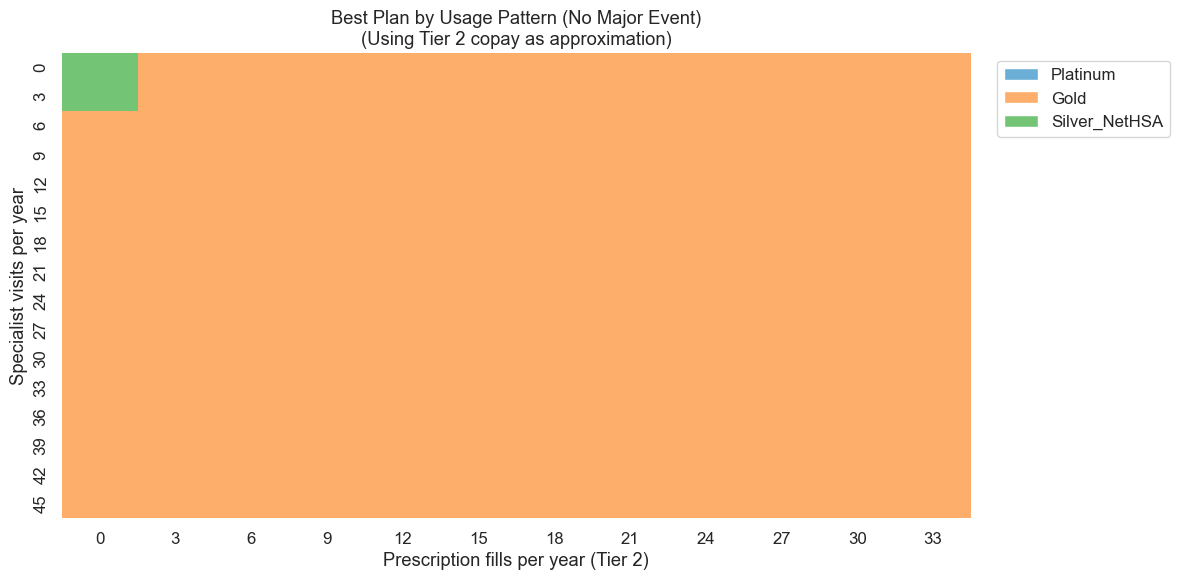

In [84]:
grid = df[df["MajorEvent"] == 0].pivot(
    index="Specialist_Visits", 
    columns="Rx_Fills",  # Changed from Total_Rx back to Rx_Fills
    values="BestPlan"
)

color_map = {"Platinum": "#6baed6", "Gold": "#fdae6b", "Silver_NetHSA": "#74c476"}
plan_to_index = {plan: i for i, plan in enumerate(color_map.keys())}

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    grid.map(lambda x: plan_to_index.get(x, np.nan)),
    cmap=list(color_map.values()),
    cbar=False,
    ax=ax,
    vmin=0,
    vmax=len(color_map)-1
)
ax.set_title("Best Plan by Usage Pattern (No Major Event)\n(Using Tier 2 copay as approximation)")
ax.set_xlabel("Prescription fills per year (Tier 2)")
ax.set_ylabel("Specialist visits per year")

legend_elements = [Patch(facecolor=color, label=plan) for plan, color in color_map.items()]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()


## 5. Heatmap 2 — **Gold plan total cost gradient**

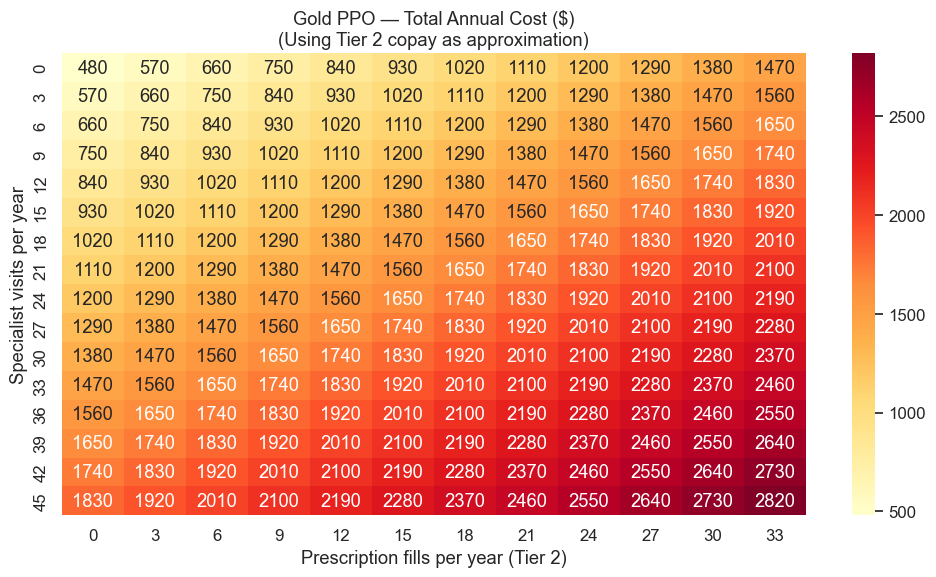

In [85]:
cost_grid = df[df["MajorEvent"] == 0].pivot(
    index="Specialist_Visits", 
    columns="Rx_Fills", 
    values="Gold"
)

plt.figure(figsize=(12, 6))
sns.heatmap(cost_grid, cmap="YlOrRd", annot=True, fmt=".0f")
plt.title("Gold PPO — Total Annual Cost ($)\n(Using Tier 2 copay as approximation)")
plt.xlabel("Prescription fills per year (Tier 2)")
plt.ylabel("Specialist visits per year")
plt.show()

## Let's look at Silver and Platinum for my case too.

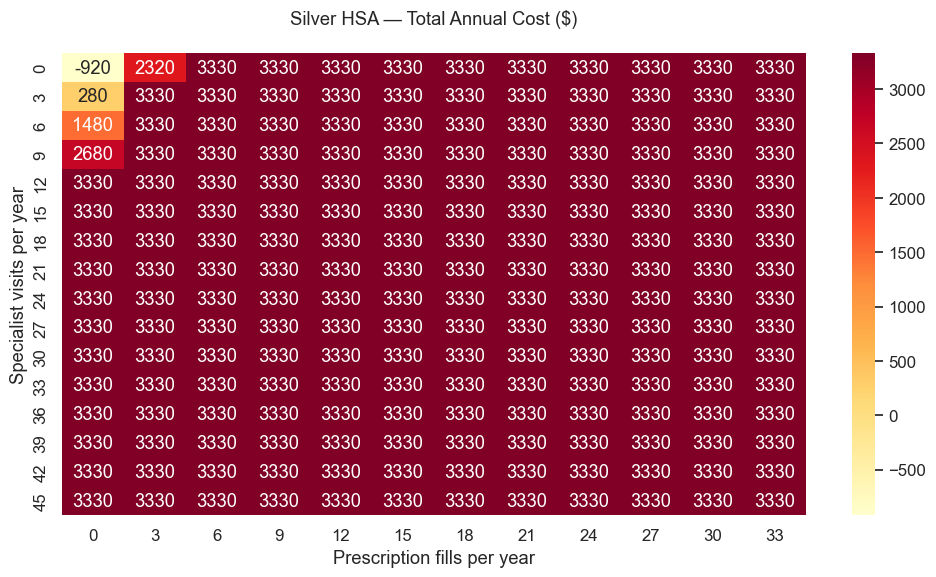

In [86]:
cost_grid = df[df["MajorEvent"] == 0].pivot(
    index="Specialist_Visits", 
    columns="Rx_Fills", 
    values="Silver_NetHSA"
)

plt.figure(figsize=(12, 6))
sns.heatmap(cost_grid, cmap="YlOrRd", annot=True, fmt=".0f")
plt.title("Silver HSA — Total Annual Cost ($)\n")
plt.xlabel("Prescription fills per year")
plt.ylabel("Specialist visits per year")
plt.show()

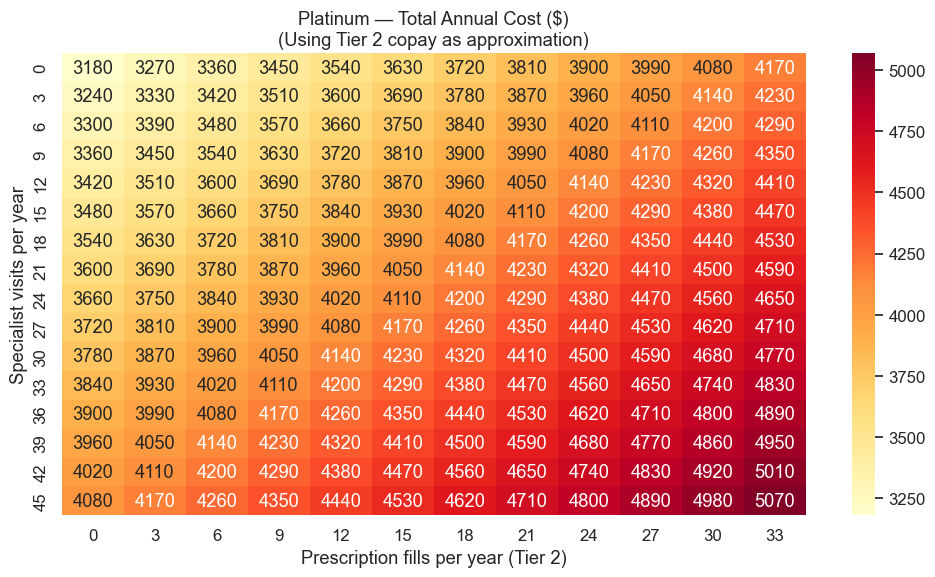

In [87]:

cost_grid = df[df["MajorEvent"] == 0].pivot(
    index="Specialist_Visits", 
    columns="Rx_Fills", 
    values="Platinum"
)

plt.figure(figsize=(12, 6))
sns.heatmap(cost_grid, cmap="YlOrRd", annot=True, fmt=".0f")
plt.title("Platinum — Total Annual Cost ($)\n(Using Tier 2 copay as approximation)")
plt.xlabel("Prescription fills per year (Tier 2)")
plt.ylabel("Specialist visits per year")
plt.show()


## 6. Heatmap 3 — **Best Plan if Major Event ($9,000 hospital cost)**

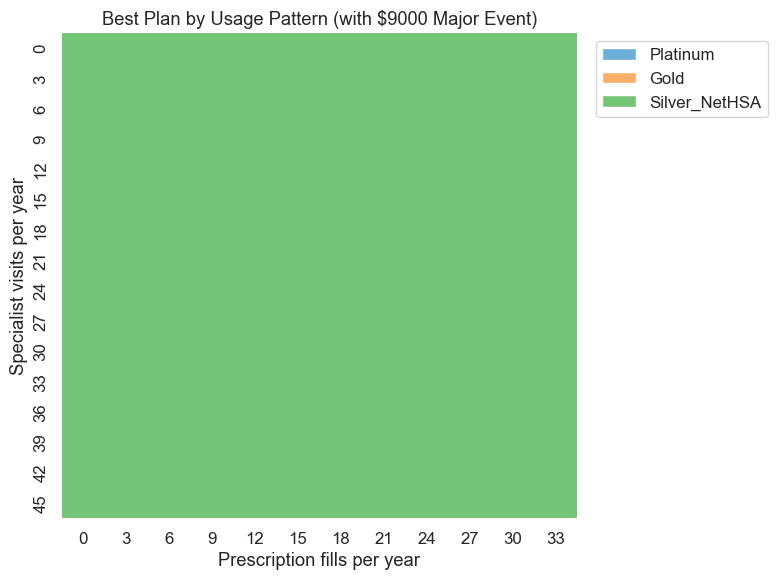

In [88]:
event_grid = df[df["MajorEvent"] == max(major_event_costs)].pivot(
    index="Specialist_Visits", columns="Rx_Fills", values="BestPlan"
)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    event_grid.map(lambda x: plan_to_index.get(x, np.nan)),  # Convert plan names to numbers
    cmap=list(color_map.values()),  # Use the hex colors in order
    cbar=False,
    vmin=0,
    vmax=len(color_map)-1
)
plt.title(f"Best Plan by Usage Pattern (with ${max(major_event_costs)} Major Event)")  
plt.xlabel("Prescription fills per year")
plt.ylabel("Specialist visits per year")

# Add legend
legend_elements = [Patch(facecolor=color, label=plan) for plan, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()


## 6. Heatmap 3 — **Best Plan if Medium Event ($4500 hospital cost)**

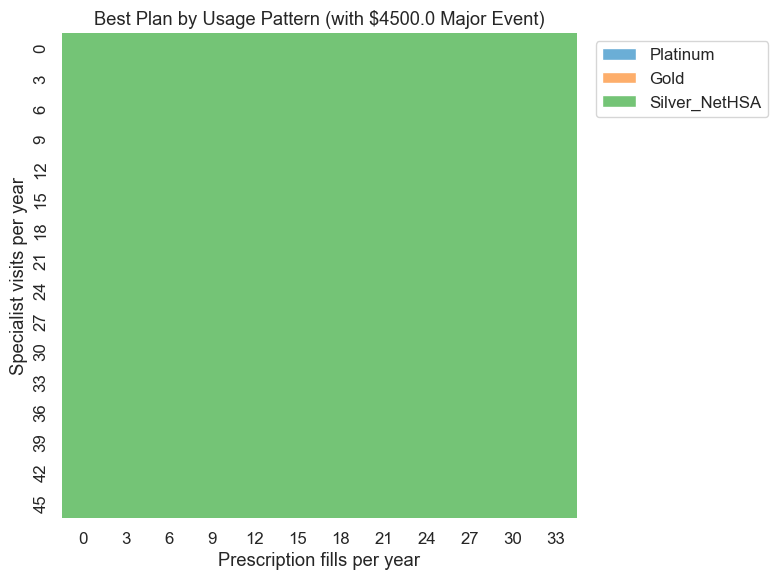

In [89]:
event_grid = df[df["MajorEvent"] == np.median(major_event_costs)].pivot(
    index="Specialist_Visits", columns="Rx_Fills", values="BestPlan"
)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    event_grid.map(lambda x: plan_to_index.get(x, np.nan)),  # Convert plan names to numbers
    cmap=list(color_map.values()),  # Use the hex colors in order
    cbar=False,
    vmin=0,
    vmax=len(color_map)-1
)
plt.title(f"Best Plan by Usage Pattern (with ${np.median(major_event_costs)} Major Event)")  
plt.xlabel("Prescription fills per year")
plt.ylabel("Specialist visits per year")

# Add legend
legend_elements = [Patch(facecolor=color, label=plan) for plan, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()